# Cancer diagnosis prediction

Hi! Mario here! In this project I'll be using the Breast Cancer Wisconsin (Diagnostic) Dataset, which can be obtained from Kaggle (https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) or from the UCI Machine Learning Repository. The idea is to predict whether a tumor is beningn or malignant.

The features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. We have the ID number, the diagnosis, and then 10 features such as radius (mean of distances from center to points on the perimeter), texture (standard deviation of gray-scale values), concavity (severity of concave portions of the contour) and so on. The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features.

## 1. Exploratory data analysis

Let's first import some packages and load the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, average_precision_score
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('cancer.csv')
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [3]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

We can see there's a strange column named 'Unnamed: 32'. Let's create our features dataframe X and the target series y, replacing benign tumors by a 0 and the malignant ones by 1.

In [38]:
X = df.drop(['id', 'Unnamed: 32', 'diagnosis'], axis = 1)
y = df['diagnosis']

y = y.replace('B', 0)
y = y.replace('M', 1)

In [39]:
counts = y.value_counts()
total = counts.sum()
print(F'Benign tumors: {counts[0]} ({round(counts[0]/total * 100)}%)')
print(F'Malignant tumors: {counts[1]} ({round(counts[1]/total * 100)}%)')

Benign tumors: 357 (63%)
Malignant tumors: 212 (37%)


The distribution of the value counts is about 60-40, so I wouldn't say we are in an imbalanced problem. Let's use the describe command to look at some statistical information.

In [6]:
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


We don't really get information from this dataframe, it's better to compare visually with respect to each class. For that, I'll use violin plots. First I'll standardize the features so that they have comparable scales.

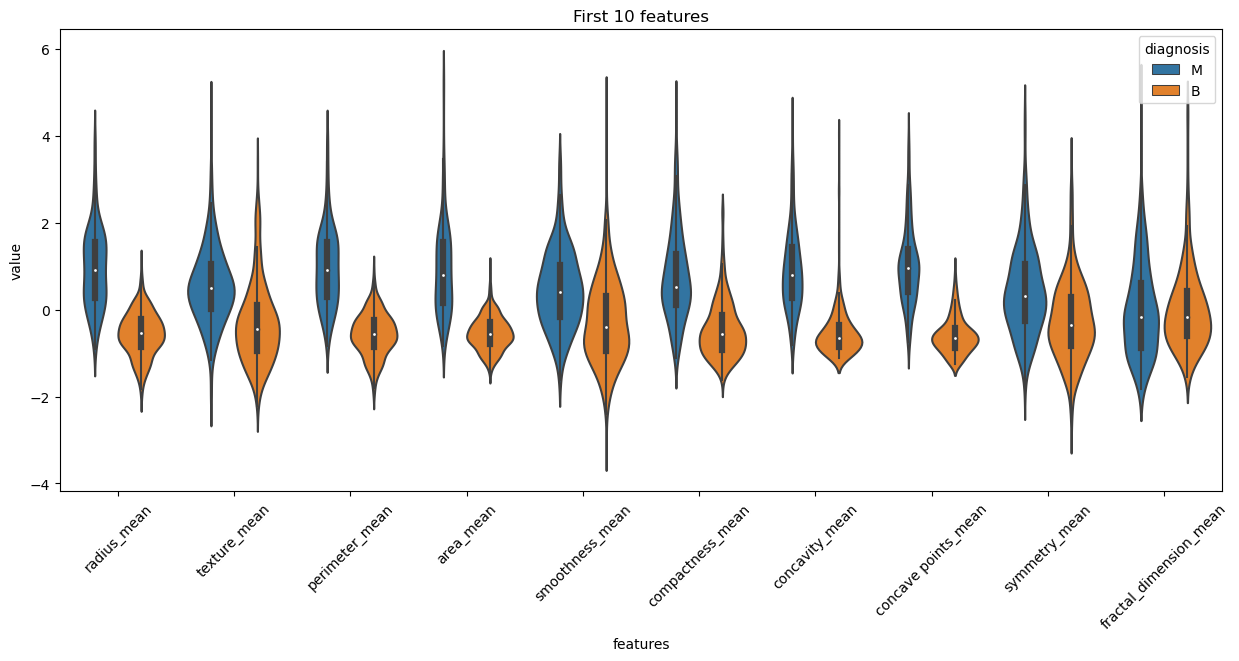

In [7]:
data = X
data_n = (data - data.mean()) / (data.std())  
data = pd.concat([y, data_n.iloc[:, 0:10]], axis = 1)
data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name='value')
plt.figure(figsize = (15, 6))
sns.violinplot(x="features", y="value", hue="diagnosis", data = data, split = False).set(title = 'First 10 features')
plt.xticks(rotation = 45);

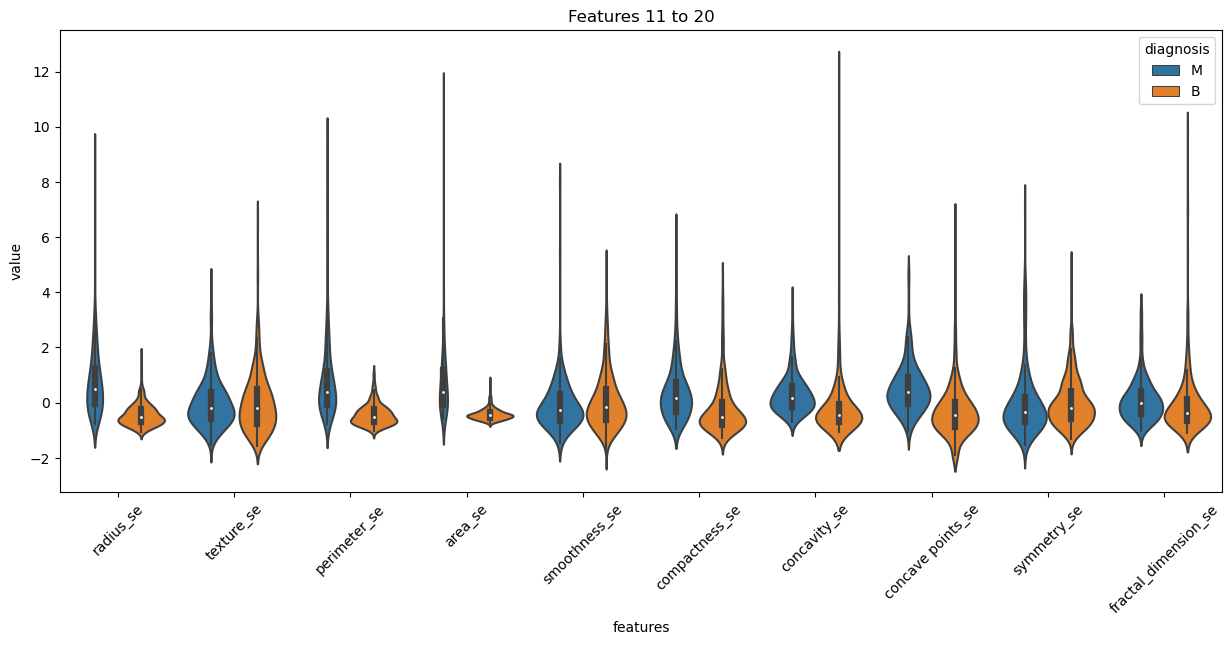

In [8]:
data = pd.concat([y, data_n.iloc[:, 10:20]], axis = 1)
data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name='value')
plt.figure(figsize = (15, 6))
sns.violinplot(x="features", y="value", hue="diagnosis", data = data, split = False).set(
    title = 'Features 11 to 20')
plt.xticks(rotation = 45);

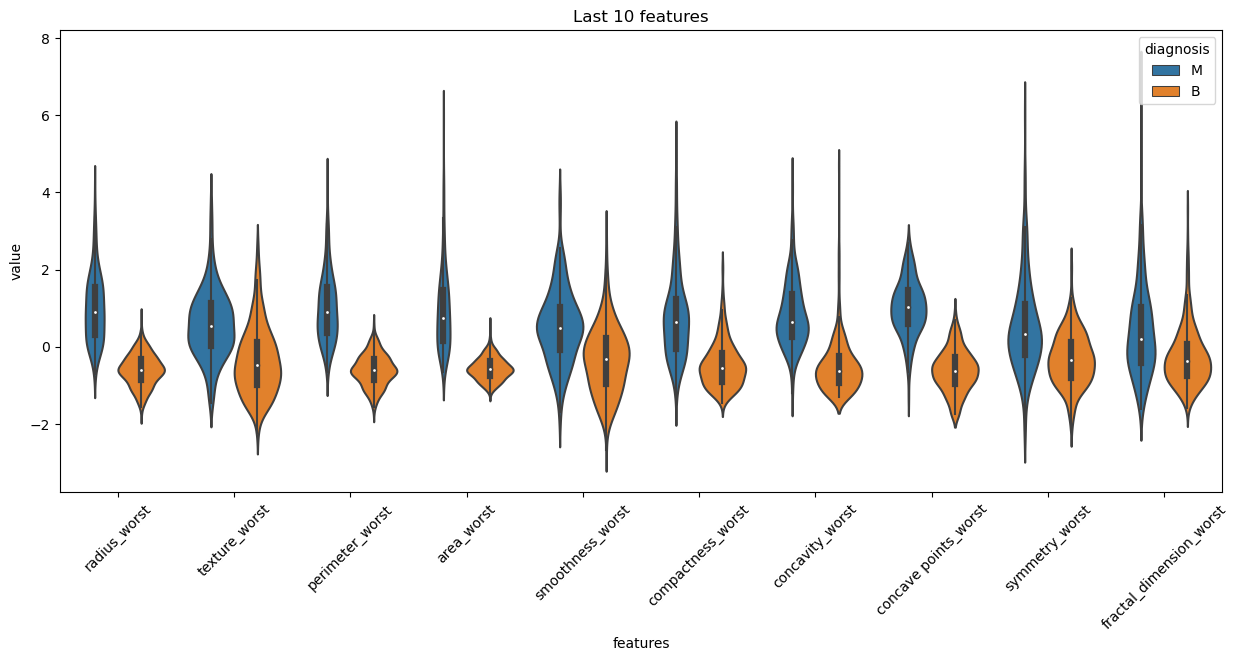

In [9]:
data = pd.concat([y, data_n.iloc[:, 20:]], axis = 1)
data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name='value')
plt.figure(figsize = (15, 6))
sns.violinplot(x="features", y="value", hue="diagnosis", data = data, split = False).set(
    title = 'Last 10 features')
plt.xticks(rotation = 45);

From the violin plots we can see conclude that the features generally tend to have greater numbers (for example, greater mean radius) in the case of the malignant tumors, with a few exceptions. The distriutions look skewed in most cases and are different between benign and malignant cells, in most ocassions, although  they look quite alike in some. Let's see the relationship between some features in order to find some correlations graphically.

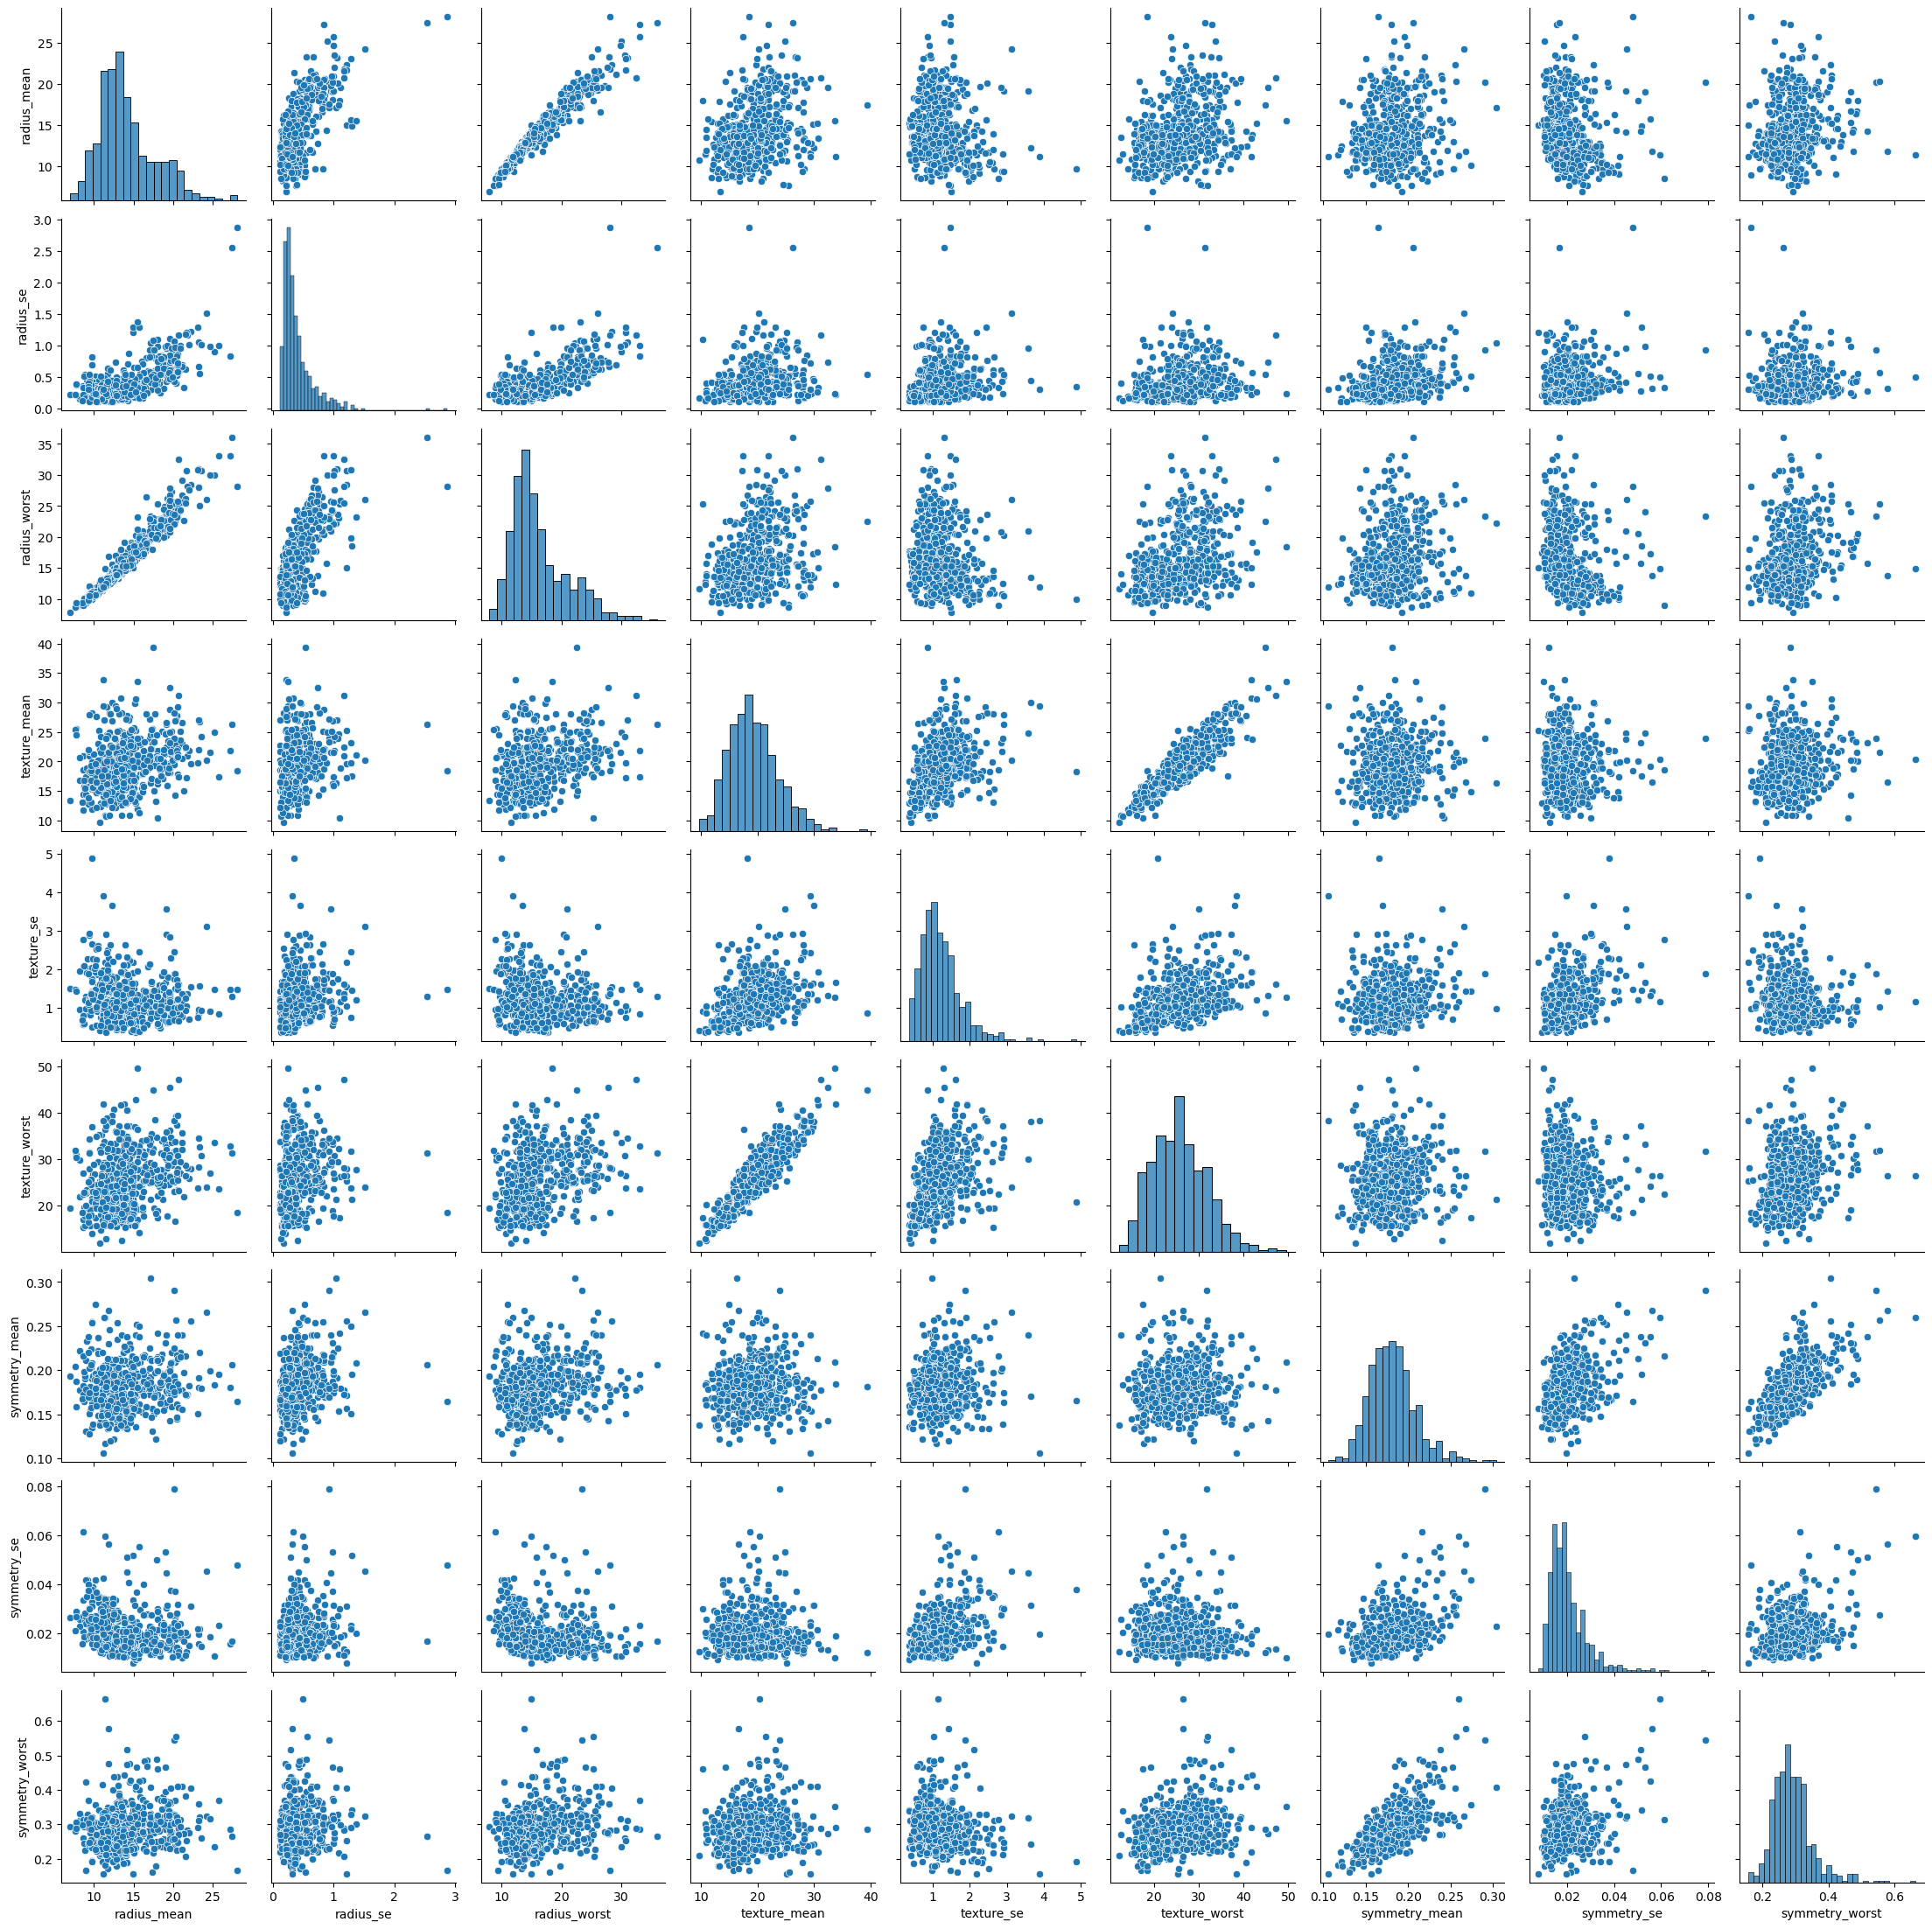

In [15]:
g = sns.PairGrid(X[['radius_mean', 'radius_se', 'radius_worst', 'texture_mean', 'texture_se', 'texture_worst',
                  'symmetry_mean', 'symmetry_se', 'symmetry_worst']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

plt.show()

We can see that the mean features have a linear relationship with their worst counterparts, and that there isn't a clear relationship between them and the standard errors, or between other features. Let's see the correlation matrix, with absolute values.

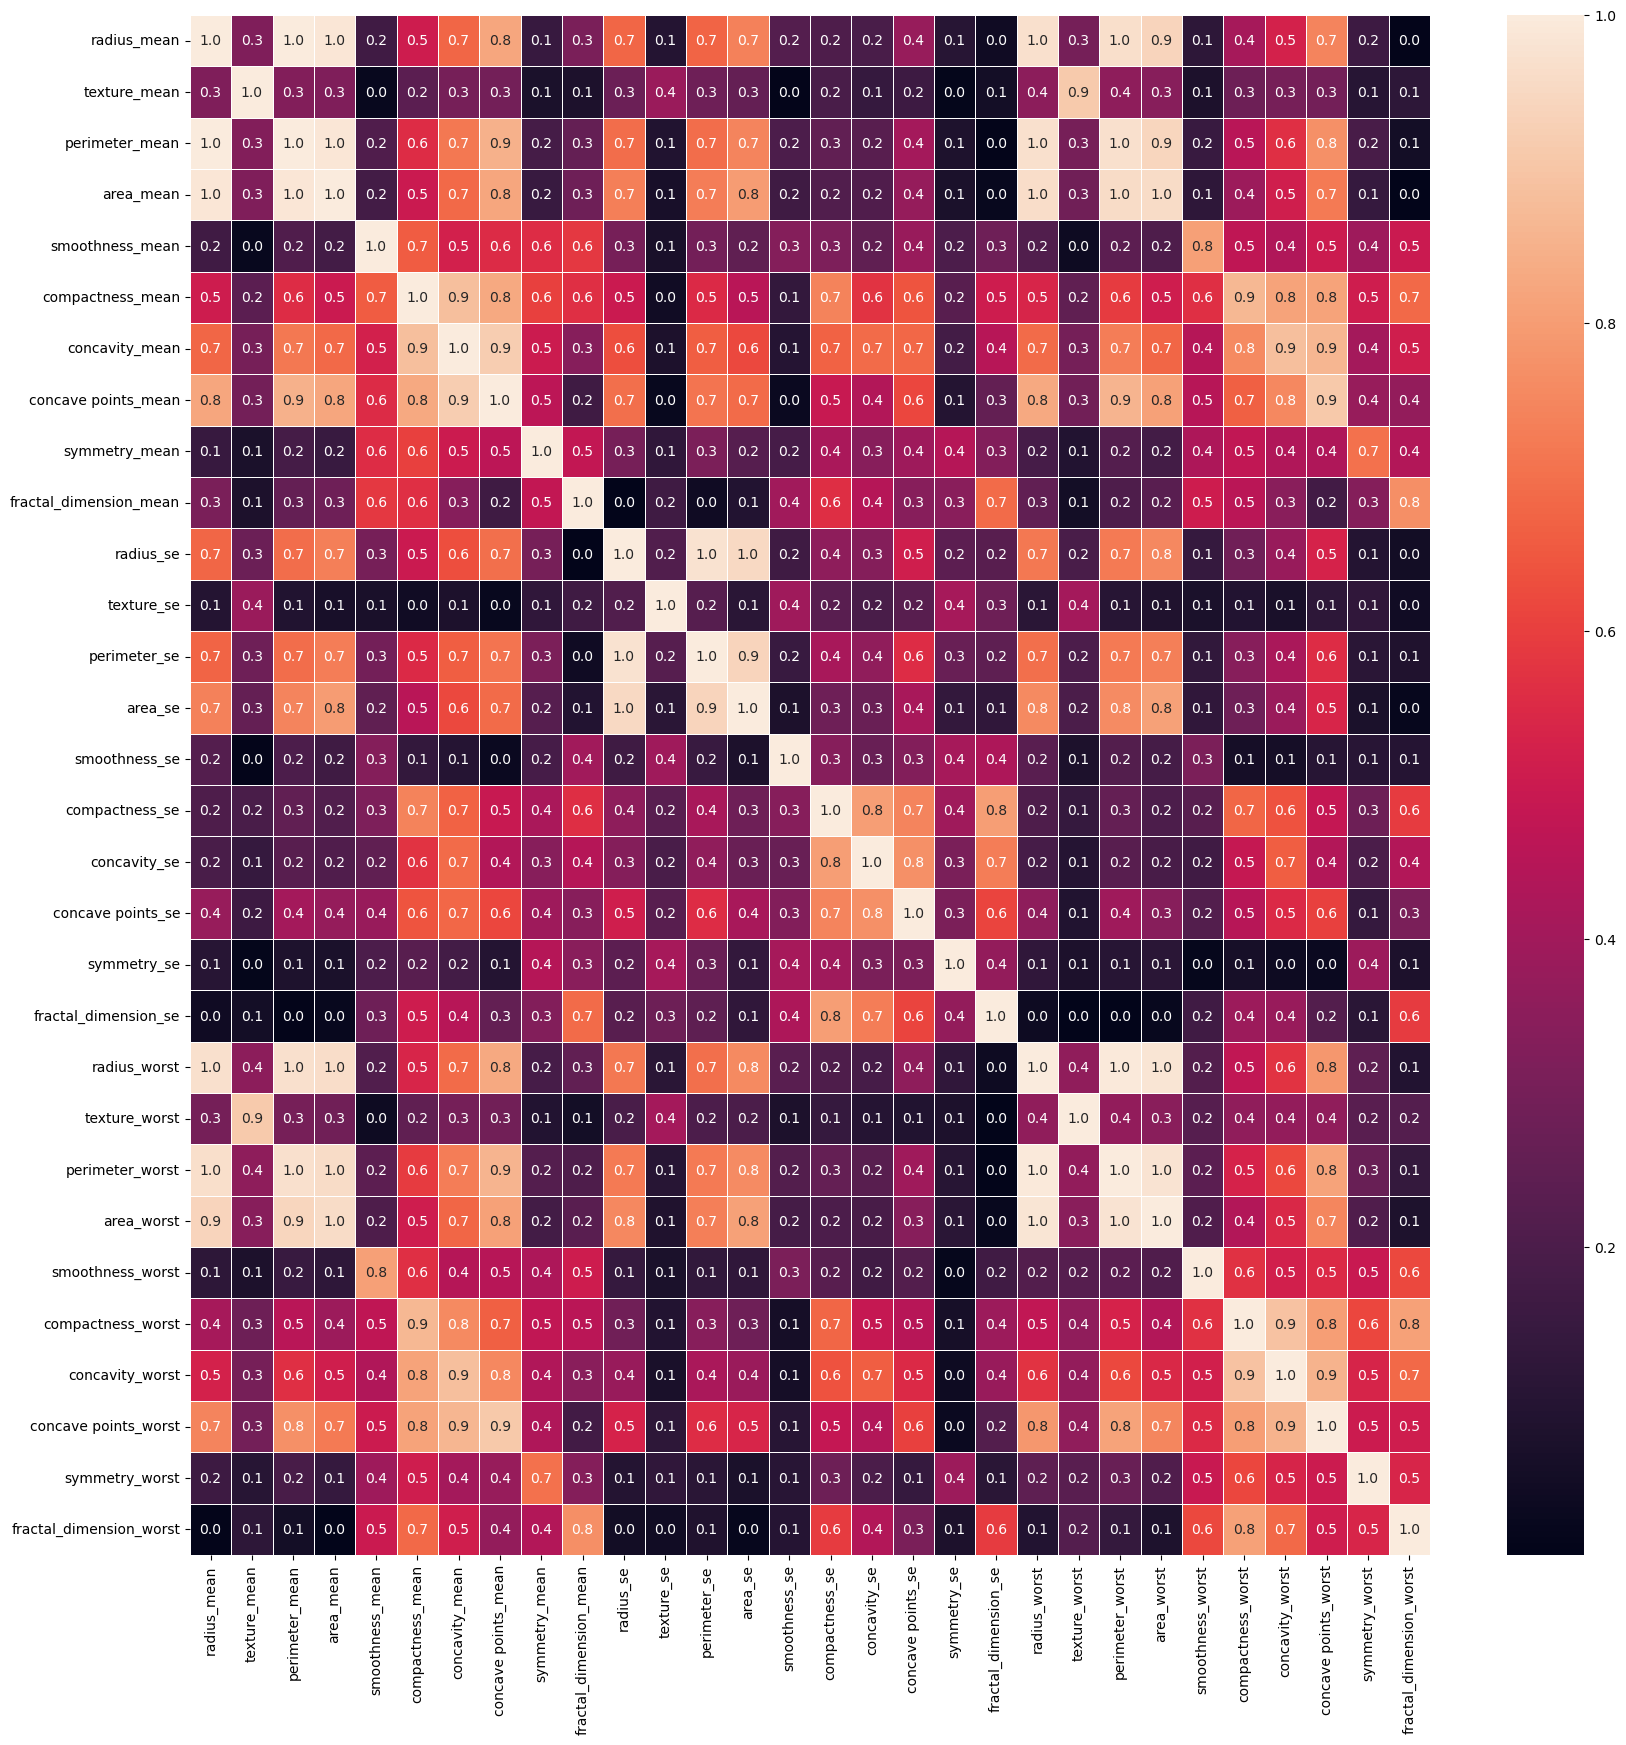

In [22]:
corr = X.corr().abs()
plt.figure(figsize = (20, 20))
sns.heatmap(corr, annot = True, linewidths=.5, fmt= '.1f');

## 2. Feature selection

There are several features with high correlations! From |0.8| to |1|. I'll drop those whose absolute value is greater than 0.9.

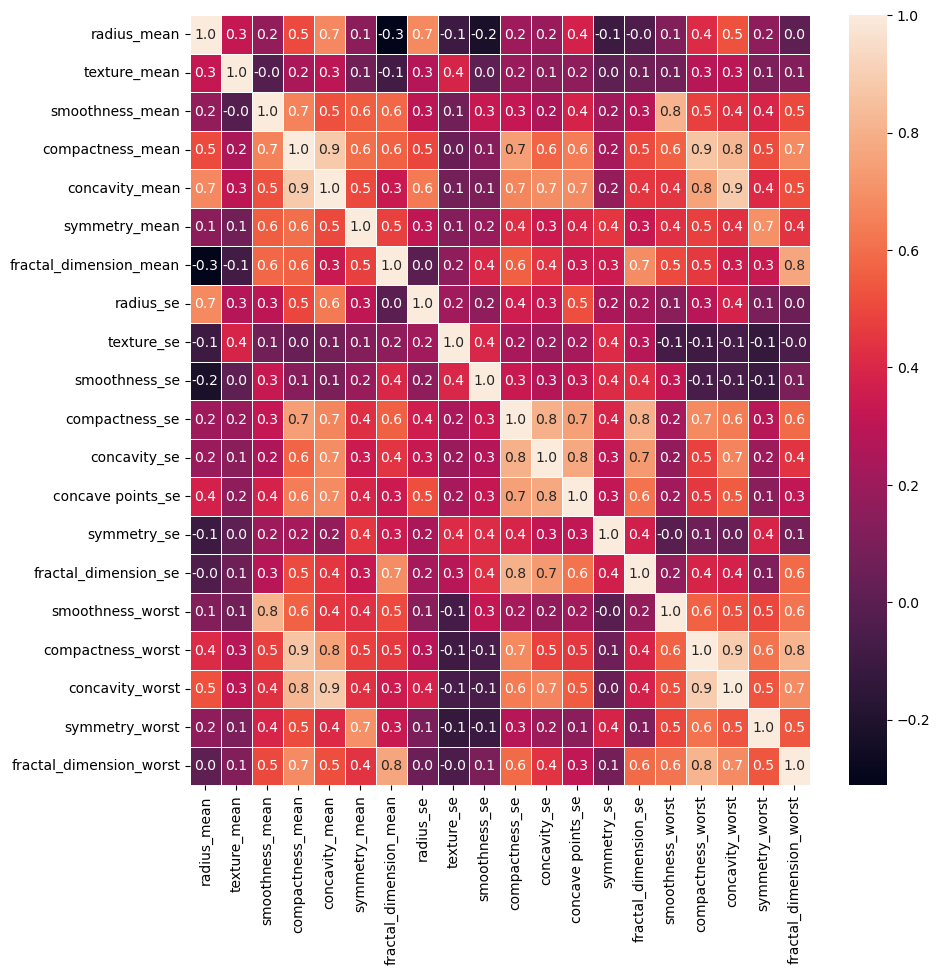

In [110]:
#The triu() function takes the upper triangle of a matrix (dataframe), k = 1 means we don't consider the diagonal
upper_triangle = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool_))

#Select columns with a correlation greater than 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

#Drop columns
X2 = X.drop(to_drop, axis=1)

plt.figure(figsize = (10, 10))
sns.heatmap(X2.corr(), annot = True, linewidths=.5, fmt= '.1f');

## 3. Classification

Now we have less than the original number of features! Time for some classification. For this problem I'll use an XGBoost Classifier, a Logistic Regression and Cross-Validation. As evaluation metrics I'll use accuracy, ROC-AUC and recall, because it would be extremely dangerous to tell people they don't have cancer when the actually have. Let's start with a default classifier. First, some functions.

In [111]:
def crossv(model, X, y):
    
    results = cross_validate(model, X, y, scoring=['accuracy', 'recall', 'roc_auc'], cv = 5, return_train_score = True)
    
    trainacc = results['train_accuracy'].mean()
    testacc = results['test_accuracy'].mean()

    trainrec = results['train_recall'].mean()
    testrec = results['test_recall'].mean()
    
    trainauc = results['train_recall'].mean()
    testauc = results['test_recall'].mean()
    
    df = pd.DataFrame({'Train accuracy': [trainacc], 'Test accuracy': [testacc], 'Train recall': [trainrec],
                      'Test recall': [testrec], 'Train AUC': [trainauc], 'Test AUC': [testauc]})
    
    return df

In [112]:
model = xgb.XGBClassifier(random_state = 0)

crossv(model, X2, y)

,Train accuracy,Test accuracy,Train recall,Test recall,Train AUC,Test AUC
0,1.0,0.96662,1.0,0.948283,1.0,0.948283


The model overfits, so let's see the most important features and choose the best ones, in order to reduce the overfitting. This using RFECV (Recursive Feature Elimination with Cross-Validation). If that doesn't work, I'll do some hyperparameter tuning.

In [147]:
selector = RFECV(model, step = 1, cv = 5, scoring = 'recall')
selector = selector.fit(X2, y)

print('Optimal number of features :', selector.n_features_)
print('Best features : ', X2.columns[selector.support_])


Optimal number of features : 15
Best features :  Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'fractal_dimension_mean', 'radius_se',
       'smoothness_se', 'compactness_se', 'concavity_se', 'symmetry_se',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'symmetry_worst'],
      dtype='object')


The best number of features is 15, let's use them and see what happens.

In [114]:
X3 = X2[['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'fractal_dimension_mean', 'radius_se',
       'smoothness_se', 'compactness_se', 'concavity_se', 'symmetry_se',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'symmetry_worst']]

crossv(model, X3, y)

,Train accuracy,Test accuracy,Train recall,Test recall,Train AUC,Test AUC
0,1.0,0.96485,1.0,0.957807,1.0,0.957807


The model has improved in recall and ROC-AUC, but it's still overfitting, so I'll do some tuning.

In [123]:
params = {'max_depth': [1, 2, 3], 'reg_lambda': [1, 5, 10, 20], 'alpha': [1, 5, 10, 20], 'gamma': [1, 2, 3, 4]}

clf = GridSearchCV(model, params, scoring = 'recall', cv = 3, return_train_score = True)

clf.fit(X3, y)

print('Best estimator: ', clf.best_estimator_)

print('Best recall: ',clf.best_score_, '\n')

Best estimator:  XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)
Best recall:  0.9342052313883299 



In [124]:
clf.best_params_

{'alpha': 1, 'gamma': 1, 'max_depth': 3, 'reg_lambda': 1}

In [125]:
model2 = xgb.XGBClassifier(random_state = 0, max_depth = 3, reg_lambda = 1, alpha = 1,  gamma = 1)
crossv(model2, X3, y)

,Train accuracy,Test accuracy,Train recall,Test recall,Train AUC,Test AUC
0,0.992531,0.952585,0.981142,0.924917,0.981142,0.924917


With the obtained parameters the model has improved, but it stills overfits, so I'll try some manual adjustments.

In [145]:
model3 = xgb.XGBClassifier(random_state = 0, max_depth = 2, reg_lambda = 600, alpha = 0,  gamma = 0)
crossv(model3, X3, y)

,Train accuracy,Test accuracy,Train recall,Test recall,Train AUC,Test AUC
0,0.95826,0.931486,0.928082,0.896899,0.928082,0.896899


With a maximum depth of 2 and a lambda parameter of 600 I have reduced the overfitting, obtaining a 93% accuracy and an almost 0.9 recall and ROC-AUC. Let's compare this to a Logistic Regression.

In [183]:
lr = LogisticRegression(random_state = 0, C = 50)

crossv(lr, X3, y)

,Train accuracy,Test accuracy,Train recall,Test recall,Train AUC,Test AUC
0,0.971882,0.966636,0.948117,0.943522,0.948117,0.943522


We can see that for C = 50, the model outperforms the XGBoost Classifier, obtaining an almost 97% accuracy, and 0.94 on the recall and AUC. Let's see how the model performs on a normal train-test split, to see the confusion matrix and the classification report.

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.33, random_state = 0, stratify = y)

In [185]:
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred = lr.predict(X_test)

print('Confusion matrix train set: \n', confusion_matrix(y_train, y_pred_train))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred))
print('')
print('Classification report train set: \n', classification_report(y_train, y_pred_train))
print('Classification report test set: \n', classification_report(y_test, y_pred))


Confusion matrix train set: 
 [[233   6]
 [  9 133]]
Confusion matrix test set: 
 [[114   4]
 [  3  67]]

Classification report train set: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       239
           1       0.96      0.94      0.95       142

    accuracy                           0.96       381
   macro avg       0.96      0.96      0.96       381
weighted avg       0.96      0.96      0.96       381

Classification report test set: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.94      0.96      0.95        70

    accuracy                           0.96       188
   macro avg       0.96      0.96      0.96       188
weighted avg       0.96      0.96      0.96       188



In this particular case, the model performs really well, obtaining a 96% accuracy and recall. We have a small number of false positives, only 3, so that's a good thing. As I used cross-validation, it should generalize well.